In [1]:
import pandas
import os
import pixiedust

Pixiedust database opened successfully


# Look at our data

In [2]:
demographics = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_demographic.csv', delimiter="\t")
display(demographics)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,STD_STATUS,STD_GENDER,STD_LANGUAGE,STD_RELIGION,BIRTH_YEAR,DEATH_YEAR,IS_DECEASED,POSTAL_CODE_3,STD_ETHNICITY,STD_INSURANCE_TYPE,STD_RACE
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:05:23,1,1,eng,nan,1923,nan,False,631.0,non-hispanic,MEDICARE,101
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:23,1,1,eng,nan,1943,nan,False,157.0,declined,MEDICARE,101
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:05:23,1,2,eng,nan,1936,nan,False,170.0,declined,MEDICARE,101
00021CA6FF03E670,BILLING,00021CA6FF03E670,2016-03-03 19:05:23,1,1,eng,nan,1941,nan,False,800.0,non-hispanic,MEDICARE,615
00024B3D2352D2D0,BILLING,00024B3D2352D2D0,2016-03-03 19:05:23,1,1,eng,nan,1936,nan,False,544.0,non-hispanic,MEDICARE,101
0002DAE1C81CC70D,BILLING,0002DAE1C81CC70D,2016-03-03 19:05:23,1,1,eng,nan,1943,nan,False,110.0,non-hispanic,MEDICARE,203
0002F28CE057345B,BILLING,0002F28CE057345B,2016-03-03 19:05:23,1,1,eng,nan,1922,nan,False,170.0,non-hispanic,MEDICARE,101
000308435E3E5B76,BILLING,000308435E3E5B76,2016-03-03 19:05:23,1,1,eng,nan,1935,nan,False,556.0,hispanic,MEDICARE,101
000345A39D4157C9,BILLING,000345A39D4157C9,2016-03-03 19:05:23,1,2,eng,nan,1976,nan,False,481.0,non-hispanic,MEDICARE,101
00036A21B65B0206,BILLING,00036A21B65B0206,2016-03-03 19:05:23,1,2,eng,nan,1938,nan,False,350.0,non-hispanic,MEDICARE,203


In [3]:
histories = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_medical_history.csv', delimiter="\t")
display(histories)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,ENCOUNTER_RECORD_ID_HASH,ENCOUNTER_JOIN_ID,ICD_CODE,ICD_VERSION,STD_MEDICAL_HISTORY_DATE,CONTACT_DATE,SNOMED_IDS
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:26:33,542192281063886,542192281063886,V58.83,ICD9,2008-09-04 00:00:00,2008-09-04 00:00:00,"275917000,166938002,166943009"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,272.4,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,"55822004,13644009,238040008,234413005,3744001,238037008,238080004,238088006,238089003,299465007,445261005,426161002,402727002,402725005,402785008,402474007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,318.2,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,31216003
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,V58.69,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,"417284009,408536007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,427.31,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,49436004
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542282281644416,542282281644416,959.4,ICD9,2009-06-23 00:00:00,2009-06-23 00:00:00,"125599006,210574006,210575007,210585008,210588005,262971000,263264005,268117002,441886002,283809003,298080001,283568001,283567006,283566002,283202002,283160004,441885003,298081002,298082009,427914009,439052006,283161000"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542282281644416,542282281644416,401.9,ICD9,2009-06-23 00:00:00,2009-06-23 00:00:00,59621000
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:26:33,542642281250669,542642281250669,564.09,ICD9,2009-10-11 00:00:00,2009-10-11 00:00:00,"236069009,163890000,430097009,432994008,31499008,197120000,21782001"
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:26:33,542642281250669,542642281250669,789.43,ICD9,2009-10-11 00:00:00,2009-10-11 00:00:00,438509009
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:26:33,542642281250669,542642281250669,V12.72,ICD9,2009-10-11 00:00:00,2009-10-11 00:00:00,429047008


In [4]:
diagnosis = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_diagnosis.csv', delimiter="\t")
display(diagnosis)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,DISORDER_CODE,ICD_CODE,ICD_VERSION,ENCOUNTER_JOIN_ID,ENCOUNTER_RECORD_ID,DIAGNOSIS_DATE,IS_PRINCIPAL,IS_ADMITTING,IS_REASON_FOR_VISIT,STATUS,CLAIM_TYPE,SNOMED_IDS
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:05:39,V58.83,V58.83,ICD9,542192281063886,542192281063886,2008-09-04 00:00:00,False,True,nan,Complete,PROFESSIONAL,"275917000,166938002,166943009"
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:05:39,V58.41,V58.41,ICD9,542192281063886,542192281063886,2008-09-04 00:00:00,True,False,nan,Complete,PROFESSIONAL,nan
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,V58.32,V58.32,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,True,False,nan,Complete,PROFESSIONAL,nan
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,V58.61,V58.61,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,nan
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,272.4,272.4,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,"55822004,13644009,238040008,234413005,3744001,238037008,238080004,238088006,238089003,299465007,445261005,426161002,402727002,402725005,402785008,402474007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,318.2,318.2,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,31216003
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,V58.69,V58.69,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,"417284009,408536007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,427.31,427.31,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,49436004
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,959.4,959.4,ICD9,542282281644416,542282281644416,2009-06-23 00:00:00,True,False,nan,Complete,PROFESSIONAL,"125599006,210574006,210575007,210585008,210588005,262971000,263264005,268117002,441886002,283809003,298080001,283568001,283567006,283566002,283202002,283160004,441885003,298081002,298082009,427914009,439052006,283161000"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,E917.4,E917.4,ICD9,542282281644416,542282281644416,2009-06-23 00:00:00,False,False,nan,Complete,PROFESSIONAL,nan


In [5]:
observations = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_observation.csv', delimiter="\t")
display(observations)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,LOINC_TEST_ID,LOINC_CATEGORY_ID,STD_UOM,STD_VALUE,STD_VALUE_TXT,STD_REPORT_STATUS,STD_VALUE_STATUS,ENCOUNTER_RECORD_ID_HASH,ENCOUNTER_JOIN_ID,OBSERVATION_DATE,OBSERVATION_HIGH_REF,OBSERVATION_LOW_REF
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,5902-2,nan,nan,nan,nan,Ordered,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,29463-7,nan,kg,75.0,random generated weight,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8302-2,nan,cm,179.0,random generated height,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8310-5,nan,C,36.7,random generated body temp,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8462-4,nan,mmHg,59.0,random generated diastolic,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8480-6,nan,mmHg,139.0,random generated systolic,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8867-4,nan,bpm,65.0,random generated heart rate,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,9279-1,nan,breaths/min,15.0,random generated resp rate,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,4548-4,nan,%,5.9,random generated HBA1C,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,48643-1,nan,mLmin,133.0,random generated eGFR,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan


# Make sure pixie app is installed

In [6]:
# !pip install -e /Users/elizabethwells/PycharmProjects/WatsonHealth/pixiedust_health

In [7]:
# from pixiedust_health import *
# PixieHealthApp().run(dialog=True)

# Create Cohorts class

In [8]:
import os
from collections import defaultdict
from six import iteritems

# Hopefully find a better way to do this if we expand to other diseases
diseaseMap = {1: {'DisplayName': 'Diabetes', 'SnomedIds': ['44054006', '359642000','81531005','237599002','199230006','609567009','237627000',
                        '9859006','190331003','703138006','314903002','314904008','190390000','314772004',
                        '314902007','190389009','313436004','1481000119100']}, 2: {'DisplayName': 'Hypertension', 'SnomedIds': ['38341003']}}


# Class for storing data and generating DataFrames and matrices for UI and machine learning
# Requires 3 pandas data frames from create_v_demographic.csv, create_v_diagnosis.csv, and create_v_observation.csv
class Cohorts:
#     def __init__(self, pathToData):
    def __init__(self, demographics, diagnosis, observations):
#         demographics = pandas.read_csv(pathToData + '/create_v_demographic.csv', delimiter="\t")
        print "demographics starting"
        self.demographics = self.__filterDemographics(demographics)
        print "demographics done"
        
#         diagnosis = pandas.read_csv(pathToData + '/create_v_diagnosis.csv', delimiter="\t")
        print "histories starting"
        self.histories = self.__filterDiagnosis(diagnosis)
#         self.diagnosis = self.__filterDiagnosis(diagnosis)
#         self.histories, self.diagnosis = self.__filterDiagnosis(diagnosis)
        print "histories done"
        
#         observations = pandas.read_csv(pathToData + '/create_v_observation.csv', delimiter="\t")
        print "observations starting"
        self.demographics = self.__getFeatures(observations)
        print "observations done"
        
    # Returns filtered demographics data frame
    # Requires original demographics chart
    def __filterDemographics(self, demographics):
        filteredDemographics = demographics[['EXPLORYS_PATIENT_ID', 'STD_GENDER', 'BIRTH_YEAR', 'STD_RACE']]
        ages = filteredDemographics['BIRTH_YEAR'].map(lambda x: 2017 - int(x))
        filteredDemographics['AGE'] = ages.values
        return filteredDemographics.drop('BIRTH_YEAR', 1)
    
    # Returns diagnosis history data frame
    # Requires original diagnosis histories chart
    def __filterDiagnosis(self, histories):
        filteredHistories = histories[['EXPLORYS_PATIENT_ID', 'DIAGNOSIS_DATE', 'SNOMED_IDS']]
        snomedIDs = filteredHistories['SNOMED_IDS'].map(lambda x: tuple(x.split(',')) if isinstance(x, str) else tuple())
        filteredHistories['SNOMED_IDS'] = snomedIDs.values
        return filteredHistories
       
    # Returns filtered observation data frame
    # Requires original observations chart
    def __getFeatures(self, observations):
        demographicCopy = self.demographics
        filteredObservations = observations[['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID', 'STD_VALUE']]
        filteredObservations = filteredObservations.groupby(['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID'], as_index=False).mean()
        loincIDs = [('HBA1C', '4548-4'), ('WEIGHT', '29463-7')]
        for label, loinc in loincIDs:
            justThisLabel = filteredObservations.loc[filteredObservations['LOINC_TEST_ID'] == loinc]
            justThisLabel = justThisLabel.rename(columns={'STD_VALUE': label})
            demographicCopy = demographicCopy.merge(justThisLabel.drop('LOINC_TEST_ID', 1))
        return demographicCopy
    
    # Returns list of (DisplayName, ID) for all diseases we have data for
    # Designed for drop-down menu in initial window of UI
    def getDiseases(self):
        return [(value['DisplayName'], key) for key, value in iteritems(diseaseMap)]
    
    # Returns Data Frame with demographics for each patient
    # Filters by patients with a certain disease if disease ID is given
    # Designed for descriptive analytics window of UI
    def getDemographics(self, diseaseID=None, negative=False):
        if diseaseID:
            if negative:
                patients = self.getPatientsWithoutDisease(diseaseID)
            else:
                patients = self.getPatientsWithDisease(diseaseID)
            # Cache last dataframe generated?
            return self.demographics.loc[self.demographics['EXPLORYS_PATIENT_ID'].isin(patients)]       
        return self.demographics
    
    # Returns a list of all patients we have a medical history for
    # Facilitates getPatientsWithoutDisease()
    def getPatients(self):
        return set(self.histories['EXPLORYS_PATIENT_ID'].values)
    
    # Returns list of IDs for patients with a given disease
    # Requires disease ID
    # Facilitates getDemographics()
    def getPatientsWithDisease(self, diseaseID):
        snomedIDs = diseaseMap[diseaseID]['SnomedIds']
        filtered = self.histories.loc[[not (set(history).isdisjoint(snomedIDs)) for history in self.histories['SNOMED_IDS']]]
        return set(filtered['EXPLORYS_PATIENT_ID'].values)
    
    # Returns list of IDs for patients without a given disease
    # Requires disease ID
    # Facilitates getDemographics()
    def getPatientsWithoutDisease(self, diseaseID):
        return self.getPatients() - self.getPatientsWithDisease(diseaseID)
    
    # Returns a numpy matrix of features
    # Filters by a certain disease if disease ID is given
    # Returns only certain features if features are specified
    # Designed to be used for machine learning component
    def getFeatureVectors(self, diseaseID=None, features=None, negative=False):
        ret = self.getDemographics(diseaseID, negative)
        if features:
            return ret[features].as_matrix()
        return ret[['STD_GENDER', 'STD_RACE', 'AGE', 'HBA1C', 'WEIGHT']].as_matrix()
    
    # Returns a Data Frame of diagnosis dates and corresponding snomed IDs for a given patient
    # Requires a patient ID
    # Facilitates getMosPriorToDiagnosis()
    def getDiagnosisHistory(self, patientID):
        patientHistory = self.histories.loc[self.histories['EXPLORYS_PATIENT_ID'] == patientID].drop('EXPLORYS_PATIENT_ID', 1)
        return patientHistory.groupby('DIAGNOSIS_DATE', as_index=False).sum()
    
    # Unfinished function being worked on by Katie
    # Gets the average value of given measurement (loincID) for twelve months before patient's diagnosis
    # May be included in demographics/feature vectors
    def getYearPriorToDiagnosis(self, patientID, loincID):
        patientObservations = self.getDiagnosisHistory(patientID)

# Create instance of Cohorts and Test

In [9]:
cohorts = Cohorts(demographics, diagnosis, observations)

demographics starting
demographics done
histories starting

/Users/elizabethwells/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/elizabethwells/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



histories done
observations starting
observations done


### Page 0: Dropdown menu

In [10]:
# from pixiedust_health.cohort import *
# cohorts = Cohorts('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data')
cohorts.getDiseases()

[('Diabetes', 1), ('Hypertension', 2)]

### Page 1: Descriptive Analytics / Charts


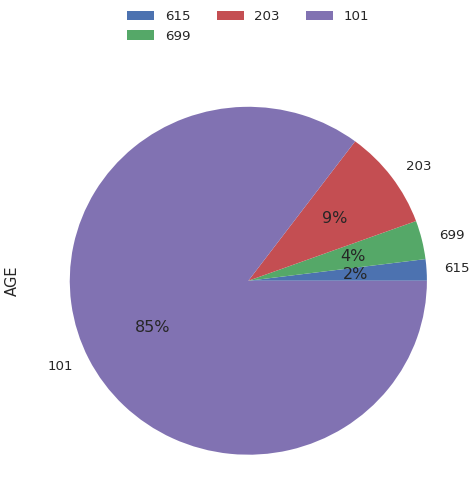

In [11]:
demographicDF = cohorts.getDemographics()
display(demographicDF)


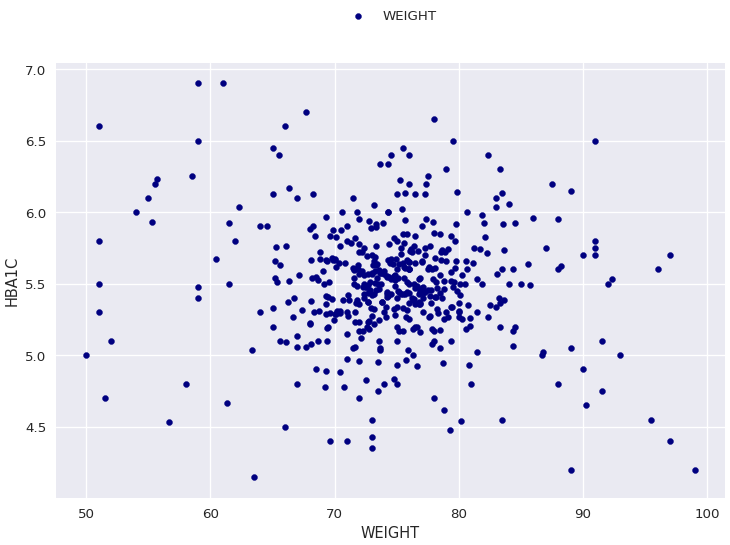

In [12]:
display(demographicDF)


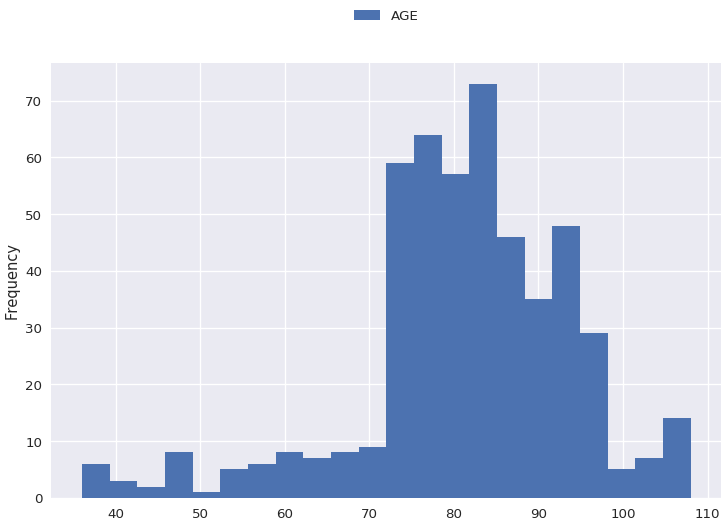

In [13]:
display(demographicDF)


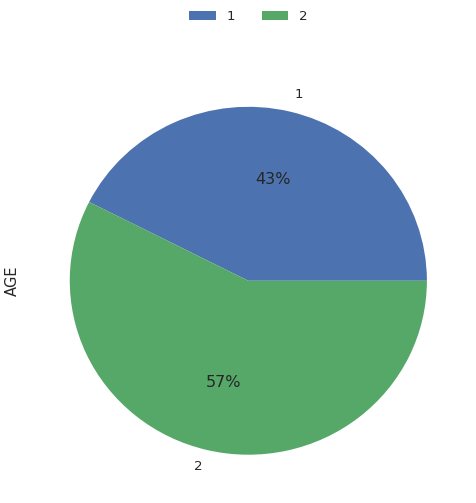

In [14]:
display(demographicDF)

In [18]:
# Sanity checks for getPatientsWithDisease() and getPatientsWithoutDisease()
print len(cohorts.getPatients())
pos = cohorts.getPatientsWithDisease(1)
neg = cohorts.getPatientsWithoutDisease(1)
print len(pos) + len(neg)
pos2 = cohorts.getPatientsWithDisease(2)
neg2 = cohorts.getPatientsWithoutDisease(2)
print len(pos2) + len(neg2)
print set(pos).isdisjoint(neg)

86705
86705
86705
True



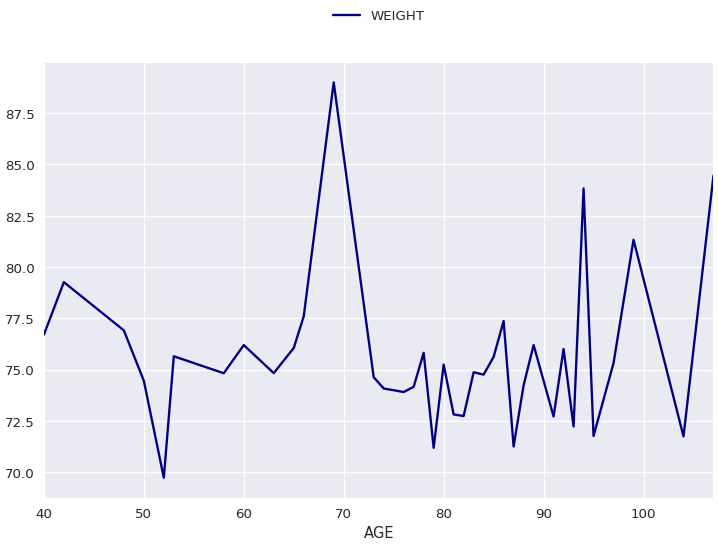

In [16]:
display(cohorts.getDemographics(2))

### Page 2: Classsification Model

In [19]:
cohorts.getFeatureVectors()

array([[   1.        ,  101.        ,   94.        ,    6.05      ,   74.        ],
       [   1.        ,  101.        ,   74.        ,    6.        ,
          74.66666667],
       [   1.        ,  101.        ,   81.        ,    5.8       ,   81.        ],
       ..., 
       [   1.        ,  101.        ,   78.        ,    6.53333333,
          66.66666667],
       [   2.        ,  101.        ,  101.        ,    5.29411765,
          78.11764706],
       [   2.        ,  101.        ,   65.        ,    5.60833333,
          75.625     ]])

In [20]:
cohorts.getFeatureVectors(2)

array([[   2.        ,  101.        ,   74.        ,    5.58333333,
          75.16666667],
       [   2.        ,  101.        ,   63.        ,    5.71111111,
          74.83333333],
       [   2.        ,  101.        ,  107.        ,    5.26923077,
          84.46153846],
       [   2.        ,  203.        ,   58.        ,    5.65862069,
          74.82758621],
       [   1.        ,  101.        ,  104.        ,    5.30625   ,   71.75      ],
       [   2.        ,  101.        ,   77.        ,    5.44      ,   77.2       ],
       [   2.        ,  203.        ,   80.        ,    5.525     ,   79.        ],
       [   2.        ,  101.        ,   92.        ,    5.76      ,   81.2       ],
       [   1.        ,  101.        ,   40.        ,    5.41020408,
          75.40816327],
       [   1.        ,  101.        ,   78.        ,    4.88333333,
          75.66666667],
       [   1.        ,  101.        ,   66.        ,    5.6       ,   76.        ],
       [   2.        ,  101.

In [21]:
cohorts.getFeatureVectors(2, ['AGE', 'STD_RACE'])

array([[ 74, 101],
       [ 63, 101],
       [107, 101],
       [ 58, 203],
       [104, 101],
       [ 77, 101],
       [ 80, 203],
       [ 92, 101],
       [ 40, 101],
       [ 78, 101],
       [ 66, 101],
       [ 85, 101],
       [ 81, 203],
       [ 81, 203],
       [ 78, 101],
       [ 81, 101],
       [ 91, 101],
       [ 85, 101],
       [ 87, 101],
       [ 82, 101],
       [ 48, 101],
       [ 50, 699],
       [ 97, 101],
       [ 79, 101],
       [ 74, 101],
       [ 85, 101],
       [ 81, 101],
       [ 74, 101],
       [ 89, 101],
       [ 60, 101],
       [ 87, 101],
       [ 83, 101],
       [ 92, 203],
       [ 93, 203],
       [ 85, 101],
       [ 77, 101],
       [ 76, 101],
       [ 89, 101],
       [ 84, 101],
       [ 78, 101],
       [ 88, 101],
       [ 53, 101],
       [ 86, 203],
       [ 83, 101],
       [ 79, 101],
       [ 65, 203],
       [ 42, 101],
       [ 91, 101],
       [ 78, 699],
       [ 88, 699],
       [ 52, 101],
       [ 80, 203],
       [ 95,

In [22]:
display(cohorts.getDiagnosisHistory('00016F745862898F'))

DIAGNOSIS_DATE,SNOMED_IDS
2009-04-18 00:00:00,"('309529002', '441124000', '440299000', '300851005', '300868009', '300869001', '300875005', '301030002', '309530007', '274739003', '94391008', '59621000', '433144002', '87486003', '43339004', '396275006', '43829003', '389159004', '443524000', '239883006', '201826000', '201825001', '239884000', '394991004', '239862000', '254779008', '55822004', '13644009', '238040008', '234413005', '3744001', '238037008', '238080004', '238088006', '238089003', '299465007', '445261005', '426161002', '402727002', '402725005', '402785008', '402474007', '94264008', '94180008', '94258001', '94261000', '94267001', '94239005', '94273000', '94209000', '94278009', '94280003', '94272005', '94234000', '94207003', '94210005', '369983003', '94208008', '94282006', '94316002', '369966007', '369974008', '369977001', '94428009', '94427004', '94461002', '94343007', '94333009', '94334003', '94340005', '94445004', '94342002', '94348003', '94352003', '94341009', '94323001', '94321004', '94319009', '369872006', '369877000', '369892004', '369893009', '369902006', '369903001', '94306005', '369921003', '94293008', '369940009', '369945004', '369947007', '369948002', '384969008', '94314004', '370013000', '94305009', '94304008', '94303002', '369910007', '94168000', '94169008', '94191001', '94173006', '94192008', '94193003', '94194009', '94195005', '94196006', '94197002', '372436009', '369818004', '242862004', '255117000', '255119002', '255124004', '274088005', '285606005', '285608006', '285633009', '285642002', '369732007', '369733002', '369867002', '369828008', '369831009', '369871004', '369806008', '369830005', '369864009', '369857007', '369764000', '369854000', '369804006', '241861008', '369853006', '369734008', '94252000', '94253005', '94356000', '94166001', '94202009', '94163009', '94326009', '14669001')"
2009-06-02 00:00:00,"('55822004', '13644009', '238040008', '234413005', '3744001', '238037008', '238080004', '238088006', '238089003', '299465007', '445261005', '426161002', '402727002', '402725005', '402785008', '402474007', '31216003', '417284009', '408536007', '49436004')"
2009-06-23 00:00:00,"('125599006', '210574006', '210575007', '210585008', '210588005', '262971000', '263264005', '268117002', '441886002', '283809003', '298080001', '283568001', '283567006', '283566002', '283202002', '283160004', '441885003', '298081002', '298082009', '427914009', '439052006', '283161000', '59621000')"
2009-09-02 00:00:00,"('398061002', '52448006', '88339003', '9345005', '278857002', '421529006', '192072002', '279982005', '229672009', '278852008', '231449007', '230290000', '230289009', '230282000', '420614009', '14760008')"
2009-09-20 00:00:00,"('58214004', '76441001', '66590003', '86325007', '300992002', '228341007', '7200002', '361272001', '399269003', '84757009', '7058009', '129834002', '129836000', '129833008', '129832003', '275928001', '370225008', '110479000', '372089002', '275927006', '78275009')"
2010-07-01 00:00:00,"('14669001', '25416002', '59621000', '367475009', '267064002', '238107002', '25064002', '30746006', '66657009')"
